# Brief

Compare the music preferences of the cities of Springfield and Shelbyville. Studying real Yandex.Music data to test the hypotheses below and compare user behavior for these two cities.

# Data 

Data on user behavior is stored in the file `/datasets/music_project_en.csv`. There is no information about the quality of the data, exploration will be required before testing the hypotheses. 

- `userID`: user identifier
- `Track`: track title
- `artist`: artist’s name
- `genre`
- `City`: user’s city
- `time`: the exact time the track was played
- `Day`: day of the week
 
# Task

Test three hypotheses<sup>1</sup>:
1. User activity differs depending on the day of the week and from city to city. 
2. On Monday mornings, Springfield and Shelbyville residents listen to different genres. This is also true for Friday evenings. 
3. Springfield and Shelbyville listeners have different preferences. In Springfield, they prefer pop, while Shelbyville has more rap fans.

<sup>1</sup>without t-tests/z-scores

**Libraries**

Common

In [840]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

**Data**

In [841]:
df = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/Basic Python/music_project_en.csv')

In [842]:
# summary stats
df.describe()

,userID,Track,artist,genre,City,time,Day
count,65079,63736,57512,63881,65079,65079,65079
unique,41748,39666,37806,268,2,20392,3
top,A8AE9169,Brand,Kartvelli,pop,Springfield,08:14:07,Friday
freq,76,136,136,8850,45360,14,23149


In [843]:
df.head(10)

,userID,Track,artist,genre,City,time,Day
0,FFB692EC,Kamigata To Boots,The Mass Missile,rock,Shelbyville,20:28:33,Wednesday
1,55204538,Delayed Because of Accident,Andreas Rönnberg,rock,Springfield,14:07:09,Friday
2,20EC38,Funiculì funiculà,Mario Lanza,pop,Shelbyville,20:58:07,Wednesday
3,A3DD03C9,Dragons in the Sunset,Fire + Ice,folk,Shelbyville,08:37:09,Monday
4,E2DC1FAE,Soul People,Space Echo,dance,Springfield,08:34:34,Monday
5,842029A1,Chains,Obladaet,rusrap,Shelbyville,13:09:41,Friday
6,4CB90AA5,True,Roman Messer,dance,Springfield,13:00:07,Wednesday
7,F03E1C1F,Feeling This Way,Polina Griffith,dance,Springfield,20:47:49,Wednesday
8,8FA1D3BE,L’estate,Julia Dalia,ruspop,Springfield,09:17:40,Friday
9,E772D5C0,Pessimist,NaN,dance,Shelbyville,21:20:49,Wednesday


In [844]:
# general info.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65079 entries, 0 to 65078
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0     userID  65079 non-null  object
 1   Track     63736 non-null  object
 2   artist    57512 non-null  object
 3   genre     63881 non-null  object
 4     City    65079 non-null  object
 5   time      65079 non-null  object
 6   Day       65079 non-null  object
dtypes: object(7)
memory usage: 3.5+ MB


`Findings`

- userID and City columns have extra spacing

- Track, City and Day will need to be converted to lowercase

- time may be converted to datetime

- perceived null values from Track, artist and genre

In [845]:
# column name transformations
df.columns = df.columns.str.lower().str.strip()

In [846]:
# missing value search
df_nan = pd.DataFrame(data=[df.isna().sum().tolist(), ['{:.2f}'.format(i)+'%' \
           for i in (df.isna().sum()/df.shape[0]*100).tolist()]], 
           columns=df.columns, index=['NaN Count', 'NaN Percent']).transpose()

df_nan.style.background_gradient(cmap='Grays', subset=['NaN Count'])

,NaN Count,NaN Percent
userid,0,0.00%
track,1343,2.06%
artist,7567,11.63%
genre,1198,1.84%
city,0,0.00%
time,0,0.00%
day,0,0.00%


`Findings`

- 2 out of the 3 columns with NaN values are under the 5% threshold. `artist` is way above the threshold

- The missing values under `genre` might impact our analysis and/or hypothesis testing

    - Taking into account the columns and their values, we'll replace the missing values with 'unknown' 

Replace the missing values in `'track'`, `'artist'`, and `'genre'` with the string `'unknown'`. To do this, create the `columns_to_replace` list, loop over it with `for`, and replace the missing values in each of the columns:

In [847]:
replace_cat = ['track', 'artist', 'genre']
df[replace_cat] = df[replace_cat].apply( lambda x: x.replace(np.nan, 'unknown') )

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65079 entries, 0 to 65078
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userid  65079 non-null  object
 1   track   65079 non-null  object
 2   artist  65079 non-null  object
 3   genre   65079 non-null  object
 4   city    65079 non-null  object
 5   time    65079 non-null  object
 6   day     65079 non-null  object
dtypes: object(7)
memory usage: 3.5+ MB


In [848]:
# counting missing values
df.isna().any()

userid    False
track     False
artist    False
genre     False
city      False
time      False
day       False
dtype: bool

In [849]:
# datatype transformation, time
df['time'] = df['time'].apply(pd.to_datetime, format='%H:%M:%S', utc = True).dt.strftime('%H:%M:%S')

In [850]:
# checking for duplicate rows
duplicated = df.duplicated()
# taking a closer look at the duplicate rows to show actual similarity
filter_df = df.loc[df.track == 'We Are Number One']

# column names to take a closer look at
column_names = ['userid', 'track', 'artist']
duplicates = df.duplicated(subset = column_names, keep=False)

# dropping duplicates, leveraging subsets
df = df.drop_duplicates(subset=['userid', 'track', 'time'], keep='first')

`Findings`

- There were 3826 rows initially with duplicates. Looking at this a bit deeper showed some duplicated rows not actually being fully duplicate

    - We filter and create a few views to see how we can massage the data to take the above into account. We are left with 61,244 rows vs. the original 65,079.

In [851]:
# analyzing our genre column to take a look at possible issues with grammatical errors
unique_list = df['genre'].sort_values(ascending=True).unique()
print(list(unique_list))

['acid', 'acoustic', 'action', 'adult', 'africa', 'afrikaans', 'alternative', 'ambient', 'americana', 'animated', 'anime', 'arabesk', 'arabic', 'arena', 'argentinetango', 'art', 'audiobook', 'avantgarde', 'axé', 'baile', 'balkan', 'beats', 'bigroom', 'black', 'bluegrass', 'blues', 'bollywood', 'bossa', 'brazilian', 'breakbeat', 'breaks', 'broadway', 'cantautori', 'cantopop', 'canzone', 'caribbean', 'caucasian', 'celtic', 'chamber', 'children', 'chill', 'chinese', 'choral', 'christian', 'christmas', 'classical', 'classicmetal', 'club', 'colombian', 'comedy', 'conjazz', 'contemporary', 'country', 'cuban', 'dance', 'dancehall', 'dancepop', 'dark', 'death', 'deep', 'deutschrock', 'deutschspr', 'dirty', 'disco', 'dnb', 'documentary', 'downbeat', 'downtempo', 'drum', 'dub', 'dubstep', 'eastern', 'easy', 'electronic', 'electropop', 'emo', 'entehno', 'epicmetal', 'estrada', 'ethnic', 'eurofolk', 'european', 'experimental', 'extrememetal', 'fado', 'film', 'fitness', 'flamenco', 'folk', 'folklor

`Findings`

Looking at unique values under the `genre` column we find duplicates of the genre 'hiphop' at varying degrees:

- hip
- hop
- hip-hop

In [852]:
def replace_wrong_genres(column, wrong_genres):
    """Function to replace genres with grammatical issues. 
    Takes in the wrong genres and the revised genre as input.
    """
    df[column] = df[column].replace(wrong_genres)


In [853]:
# replace mapping
replace_map = {'hip':'hiphop','hop':'hiphop', 'hip-hop': 'hiphop'}

# function call
replace_wrong_genres('genre', replace_map)

**Hypothesis Testing**

First hypothesis: User activity differs depending on the day of the week and from city to city

In [854]:
# transforming a few object types into categories for groupings
cols_to_trans = ['genre', 'city', 'day']
df[cols_to_trans] = df[cols_to_trans].astype('category')

# grouping by city to see track counts
df.groupby(['city'], observed=True)['track'].size().sort_values(ascending=False)

city
Springfield    42736
Shelbyville    18508
Name: track, dtype: int64

In [855]:
# grouping by city and day to see track count split
df.groupby(['city','day'], observed=True)['track'].count().sort_values()

city         day      
Shelbyville  Monday        5613
             Friday        5894
             Wednesday     7001
Springfield  Wednesday    11054
             Monday       15737
             Friday       15945
Name: track, dtype: int64

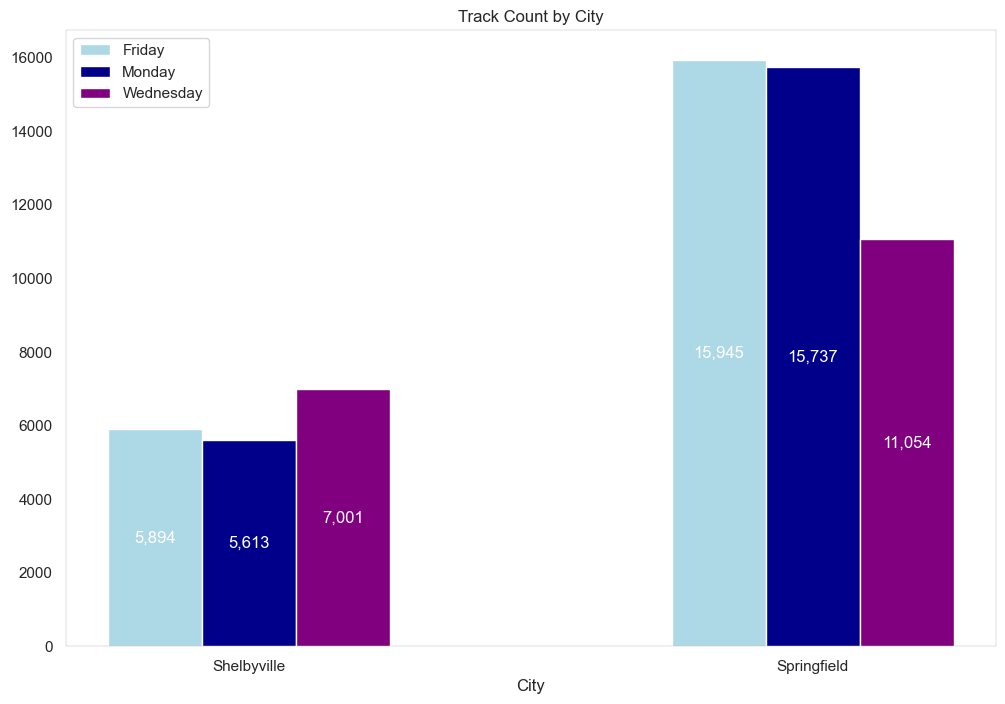

In [856]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(12, 8))

df_pivot = pd.pivot_table(df,
                          observed=True,
                          values="track", 
                          index="city", 
                          columns="day",
                          aggfunc={'count'})

df_pivot.plot.bar(ax=ax, color = ['lightblue', 'darkblue', 'purple'])

ax.autoscale()
plt.title("Track Count by City")
plt.xlabel('City')
plt.xticks(rotation=0)
ax.legend(['Friday', 'Monday', 'Wednesday'])
bottoms = {}

for bars in ax.containers:
    for bar in bars:
        x, y = bar.get_xy()
        h = bar.get_height()
        if x in bottoms:
            bar.set_y(bottoms[x])
            bottoms[x] += h
        else:
            bottoms[x] = h

for c in ax.containers:
    labels = [f'{round((v.get_height())):,}' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='white')
        
        
plt.show()

`Findings`

- Springfield has more tracks played than Shelbyville. But that does not imply that citizens of Springfield listen to music more often. This city is simply bigger, and there are more users

- Friday is the day with the most tracks played, which matches our summary statistics table we initially created. Monday follows close behind with Wednesday at the lower end of the track count

    - With that said, Wednesday is the 'busiest' music day of the week for Shelbyville. We don't have enough evidence to reject our null hypothesis

Second hypothesis: On Monday mornings, Springfield and Shelbyville residents listen to different genres. This is also true for Friday evenings. 

In [857]:
# creating DataFrames for each city
springfield_df = df.loc[df.city == 'Springfield']
shelbyville_df = df.loc[df.city == 'Shelbyville']

In [858]:
def genre_weekday(df, day, time1, time2, n):
    """Function to generate a genre top n view based on city, day and time.
    Params: DataFrame, day as a string, time as a string and n as an integer.
    Returns: a sorted DataFrame
    """
    ## filters based on day and time
    df_filter = df[(df['day'] == day) & (df['time'].between(time1, time2))]
    
    # grouping followed by count and sorting
    genre_df = df_filter.groupby('genre', observed=True)['genre'].count().sort_values(ascending=False)

    # returning the grouped DataFrame with the number of top values we want to view
    return genre_df[:n]

Overall

In [859]:
df_am_mon = genre_weekday(df, 'Monday', '07:00', '11:00', 15)
print('Monday Mornings:\n', df_am_mon.sort_values(ascending=False))
print('')

df_pm_fri = genre_weekday(df, 'Friday', '17:00', '23:00', 15)
print('Friday Evenings:\n', df_pm_fri.sort_values(ascending=False))
print('')

Monday Mornings:
 genre
pop            999
dance          731
rock           636
electronic     627
hiphop         366
ruspop         250
rusrap         230
alternative    222
world          217
classical      197
unknown        179
metal          147
jazz           144
soundtrack     126
folk           121
Name: genre, dtype: int64

Friday Evenings:
 genre
pop            969
rock           733
dance          705
electronic     697
hiphop         370
world          262
alternative    226
classical      223
ruspop         217
rusrap         201
jazz           172
unknown        157
soundtrack     145
metal          127
rnb            121
Name: genre, dtype: int64


Mondays

In [860]:
# monday mornings in Springfield
spring_am_mon = genre_weekday(springfield_df, 'Monday', '07:00', '11:00', 15)
print('Springfield Monday Mornings:\n', spring_am_mon.sort_values(ascending=False))
print('')

# monday mornings in Shelbyville
shelby_am_mon = genre_weekday(shelbyville_df, 'Monday', '07:00', '11:00', 15)
print('Shelbyville Monday Mornings:\n', shelby_am_mon.sort_values(ascending=False))

Springfield Monday Mornings:
 genre
pop            781
dance          549
electronic     480
rock           474
hiphop         286
ruspop         186
world          181
rusrap         175
alternative    164
unknown        161
classical      157
metal          120
jazz           100
folk            97
soundtrack      95
Name: genre, dtype: int64

Shelbyville Monday Mornings:
 genre
pop            218
dance          182
rock           162
electronic     147
hiphop          80
ruspop          64
alternative     58
rusrap          55
jazz            44
classical       40
world           36
rap             32
soundtrack      31
rnb             27
metal           27
Name: genre, dtype: int64


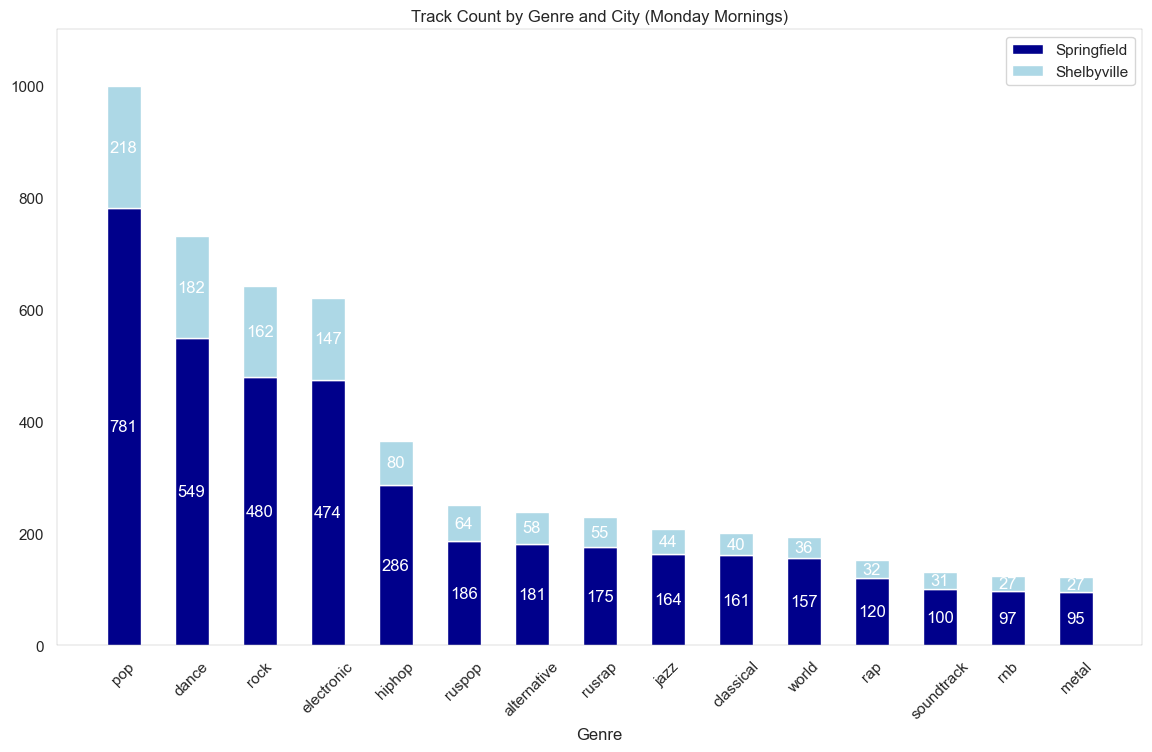

In [861]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(14, 8), nrows=1)

spring_am_mon.plot(kind='bar',
               ax=ax,
               color = ['darkblue']
                   )
shelby_am_mon.plot(kind='bar',
               ax=ax,
               color = ['lightblue']
                   )

ax.autoscale()
plt.title("Track Count by Genre and City (Monday Mornings)")
plt.xlabel('Genre')
plt.xticks(rotation=45)
ax.legend(['Springfield', 'Shelbyville'])
bottoms = {}

for bars in ax.containers:
    for bar in bars:
        x, y = bar.get_xy()
        h = bar.get_height()
        if x in bottoms:
            bar.set_y(bottoms[x])
            bottoms[x] += h
        else:
            bottoms[x] = h

for c in ax.containers:
    labels = [f'{round((v.get_height())):,}' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='white')
        
ax.set_ylim([0, 1100])     
plt.show()

Fridays

In [862]:
# friday evenings in Springfield
spring_pm_fri = genre_weekday(springfield_df, 'Friday', '17:00', '23:00', 15)
print('Springfield Friday Evenings:\n', spring_pm_fri.sort_values(ascending=False))
print('')

# friday evenings in Shelbyville
shelby_pm_fri = genre_weekday(shelbyville_df, 'Friday', '17:00', '23:00', 15)
print('Shelbyville Friday Evenings:\n', shelby_pm_fri.sort_values(ascending=False))

Springfield Friday Evenings:
 genre
pop            713
rock           517
dance          495
electronic     482
hiphop         273
world          208
ruspop         170
classical      163
alternative    163
rusrap         142
jazz           111
unknown        110
soundtrack     105
rnb             90
metal           88
Name: genre, dtype: int64

Shelbyville Friday Evenings:
 genre
pop            256
rock           216
electronic     215
dance          210
hiphop          97
alternative     63
jazz            61
classical       60
rusrap          59
world           54
unknown         47
ruspop          47
soundtrack      40
metal           39
rap             36
Name: genre, dtype: int64


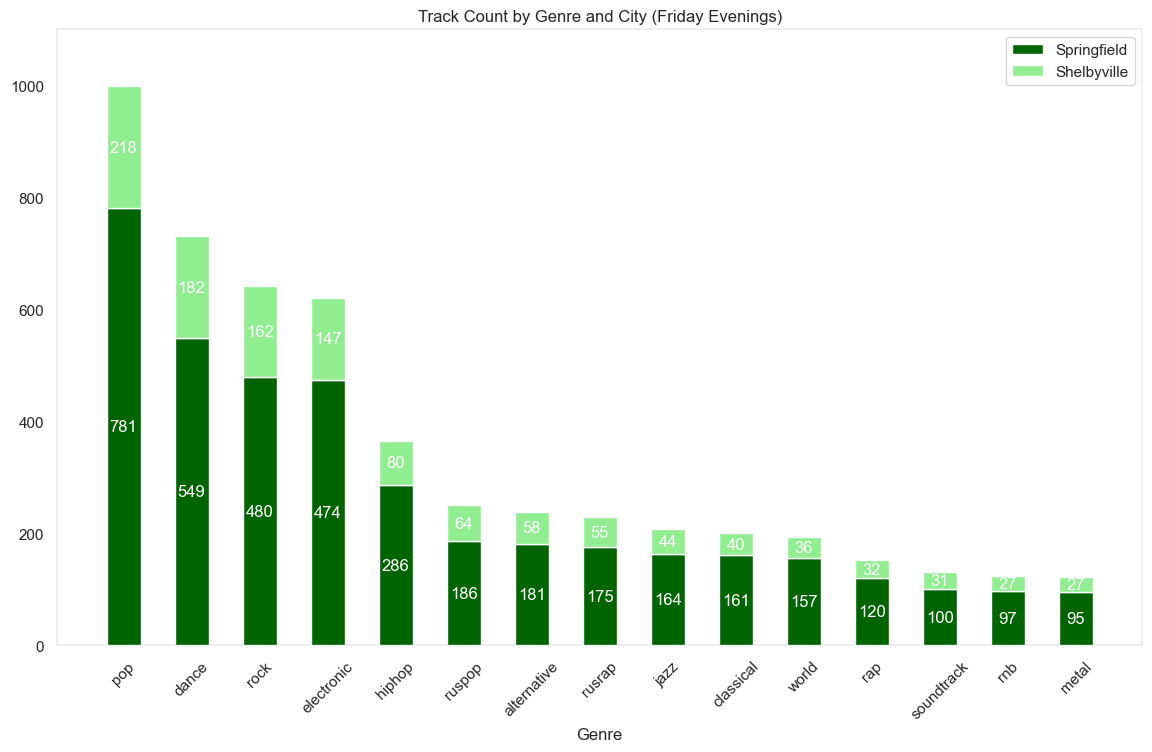

In [863]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(14, 8), nrows=1)

spring_am_mon.plot(kind='bar',
               ax=ax,
               color = ['darkgreen']
                   )
shelby_am_mon.plot(kind='bar',
               ax=ax,
               color = ['lightgreen']
                   )

ax.autoscale()
plt.title("Track Count by Genre and City (Friday Evenings)")
plt.xlabel('Genre')
plt.xticks(rotation=45)
ax.legend(['Springfield', 'Shelbyville'])
bottoms = {}

for bars in ax.containers:
    for bar in bars:
        x, y = bar.get_xy()
        h = bar.get_height()
        if x in bottoms:
            bar.set_y(bottoms[x])
            bottoms[x] += h
        else:
            bottoms[x] = h

for c in ax.containers:
    labels = [f'{round((v.get_height())):,}' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='white')
        
ax.set_ylim([0, 1100])     
plt.show()

`Findings`

Comparing the top 15 genres on Monday morning, we draw the following conclusions:

Users from Springfield and Shelbyville listen to similar music. The top five genres are the same, only rock and dance have switched places.

For Monday mornings:

In Springfield, the number of missing values from the `'unknown'` genre come in 10th on Monday mornings. Meaning that missing values make up a considerable portion of the data, which may be a basis for questioning the reliability of our conclusions/hypothesis.

For Friday evenings:

The situation is similar. Individual genres vary somewhat, but on the whole, the top 15 is similar for the two cities. Thus, the second hypothesis has been partially proven true:

- Users listen to similar music at the beginning and end of the week.
- There is no substantial difference between Springfield and Shelbyville. In both cities, pop is the most popular genre.

The number of missing values makes this result a bit questionable. In Springfield, there are so many that they affect our top 15. Things might have looked different if we were not missing these values.

Third Hypothesis: Springfield and Shelbyville listeners have different preferences. In Springfield, they prefer pop, while Shelbyville has more rap fans.

In [864]:
# 
springfield_genres = springfield_df.groupby('genre', observed=True)['genre'].size().sort_values(ascending=False).head(10)
print('Springfield Genre Distribution:\n', springfield_genres)
print('')
shelbyville_genres = shelbyville_df.groupby('genre', observed=True)['genre'].size().sort_values(ascending=False).head(10)
print('Shelbyville Genre Distribution:\n', shelbyville_genres)
print('')
print('Overall Genre Distribution per City (Top 10):')
df.groupby(['genre','city'], observed=True)['genre'].size().sort_values(ascending=False).head(10)


Springfield Genre Distribution:
 genre
pop            5892
dance          4435
rock           3964
electronic     3786
hiphop         2096
classical      1616
world          1432
alternative    1379
ruspop         1372
rusrap         1161
Name: genre, dtype: int64

Shelbyville Genre Distribution:
 genre
pop            2429
dance          1932
rock           1879
electronic     1735
hiphop          960
alternative     649
classical       646
rusrap          564
ruspop          538
world           515
Name: genre, dtype: int64

Overall Genre Distribution per City (Top 10):


genre       city       
pop         Springfield    5892
dance       Springfield    4435
rock        Springfield    3964
electronic  Springfield    3786
pop         Shelbyville    2429
hiphop      Springfield    2096
dance       Shelbyville    1932
rock        Shelbyville    1879
electronic  Shelbyville    1735
classical   Springfield    1616
Name: genre, dtype: int64

`Findings`

Our third hypothesis is partially proven true by:

- Pop music being the most popular genre in Springfield
- Pop genre being equally popular in Springfield and Shelbyville while Rap isn't even part of the Top 5 genres in either city

# Conclusion

We have tested the following three hypotheses:

1. User activity differs depending on the day of the week and from city to city. 
2. On Monday mornings, Springfield and Shelbyville residents listen to different genres. This is also true for Friday evenings. 
3. Springfield and Shelbyville listeners have different preferences. In Springfield, they prefer pop, while Shelbyville has more rap fans.

After analyzing the data, we concluded:

1. User activity in Springfield and Shelbyville depends on the day of the week, though the cities vary in different ways. 

    - We fail to reject the null hypothesis (first hypothesis).

2. Musical preferences do not vary significantly over the course of the week in both Springfield and Shelbyville. We can see small differences in order on Mondays, but people listen to pop music most in both cities.

    - We reject the null hypothesis (second). Keeping in mind that the result could have been different if not for the missing values.

3. It turns out that the musical preferences of users from Springfield and Shelbyville are quite similar.

    - We reject the null hypothesis (third). If there is any difference in preferences, it cannot be seen from this data.